## HD217014 Fitting & MCMC

Using the K2-24 (EPIC-203771098) dataset, we demonstrate how to use the radvel API to:

- perform a max-likelihood fit
- do an MCMC exploration of the posterior space
- plot the results


Perform some preliminary imports:

In [1]:
%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.plotting

matplotlib.rcParams['font.size'] = 14

Define a function that we will use to initialize the ``radvel.RVParameters`` and ``radvel.RVModel`` objects

In [2]:
def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(1,basis='per tc secosw sesinw logk')
    params['per1'] = 4.23078166873     # period of 1st planet
    params['tc1'] = 2072.79438    # time of inferior conjunction of 1st planet
    params['secosw1'] = 0.01
    params['sesinw1'] = 0.01
    params['logk1'] = 1.69    # velocity semi-amplitude for 1st planet
    
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0         # curvature  
    return mod

Define a simple plotting function to display the data, model, and residuals

In [3]:
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

Load up the K2-24 data. In this example the RV data and parameter starting guesses are stored in an csv file

In [4]:
rv = pd.read_csv('C:/users/rscsa/Research/radvel-master/HD217014/HD217014.csv')
# rv = rv[0:20]
t = np.array(rv.time)
vel = np.array(rv.mnvel)
errvel = np.array(rv.errvel)
ti = np.linspace(rv.time.iloc[0]-5,rv.time.iloc[-1]+5,5000*(t[-1]-t[0]))
print t

[ 13927.05042  13927.05119  13927.05193  13982.84764  13982.84838
  13982.84911  14085.79536  14085.79754  14085.79838  14337.09242
  14339.04723  14398.85734  14806.76933  14838.73086  14964.12809
  14984.09879  14985.11711  14986.11805  14987.11793  14988.11883
  14989.11379  15015.05347  15016.06772  15019.02109  15027.03102
  15041.92954  15078.08246  15106.76476  15135.72646  15189.68862
  15190.69278  15192.68715  15379.09613  15404.92999  15435.04702
  15704.08051  15729.11009  15732.02701  15732.03022  15753.07345
  15782.86016  15841.7826   16077.12909  16477.10415  16529.88511
  16584.74057  16639.68211  16847.92537  16911.77382  16913.75413
  17206.9411   17290.80939  17339.8244   17412.69204  17569.05315
  17569.05383  17569.05447  17570.01786  17717.73693]


### Fit the K2-24 RV data assuming:

1. circular orbits
2. fixed period, time of transit

Set initial guesses for the parameters

In [5]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

Choose which parameters to vary or fix

In [6]:
like.vary['curv']= False
print like

parameter                     value      vary
curv                              0      False
dvdt                              0       True
gamma                             1       True
jit                             2.6       True
logk1                          1.69       True
per1                        4.23078       True
secosw1                        0.01       True
sesinw1                        0.01       True
tc1                         2072.79       True



Plot the initial model

C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


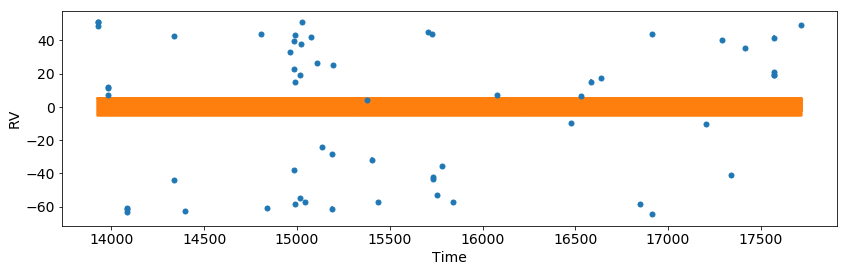

In [7]:
pl.figure()
plot_results(like)

Well that solution doesn't look very good. Now lets try to optimize the parameters set to vary by maximizing the likelihood.

Initialize a ``radvel.Posterior`` object and add some priors

In [8]:
post = radvel.posterior.Posterior(like)

print post

parameter                     value      vary
curv                              0      False
dvdt                              0       True
gamma                             1       True
jit                             2.6       True
logk1                          1.69       True
per1                        4.23078       True
secosw1                        0.01       True
sesinw1                        0.01       True
tc1                         2072.79       True

Priors
------



Maximize the likelihood and print the updated posterior object

parameter                     value      vary
curv                              0      False
dvdt                   -0.000952658       True
gamma                       6.01642       True
jit                         2.01896       True
logk1                       4.02158       True
per1                        4.23079       True
secosw1                  -0.0398526       True
sesinw1                   0.0821116       True
tc1                          2073.4       True

Priors
------



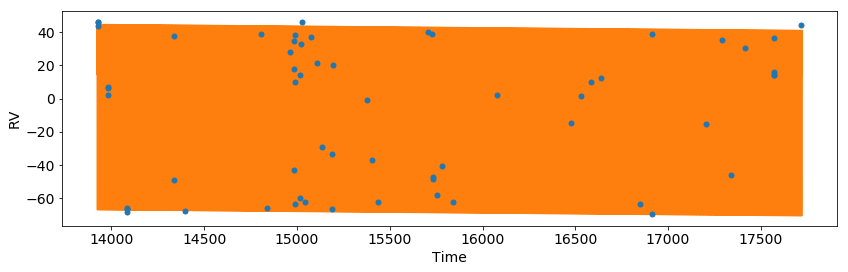

In [9]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post

That looks much better!

Now lets use Markov-Chain Monte Carlo (MCMC) to estimate the parameter uncertainties.
In this example we will run 1000 steps for the sake of speed but in practice you should let it run at least 10000 steps and ~50 walkers. If the chains converge before they reach the maximum number of allowed steps it will automatically stop.

In [10]:
df = radvel.mcmc(post,nwalkers=20,nrun=10000)

11000/200000 (5.5%) steps complete; Running 7692.30 steps/s; Mean acceptance rate = 45.1%; Min Tz = 1990.5; Max G-R = 1.11 
Discarding burn-in now that the chains are marginally well-mixed

90000/200000 (45.0%) steps complete; Running 7692.30 steps/s; Mean acceptance rate = 43.2%; Min Tz = 7246.4; Max G-R = 1.03 
Chains are well-mixed after 91000 steps! MCMC completed in 13.4 seconds




Now lets make a corner plot to display the posterior distributions.

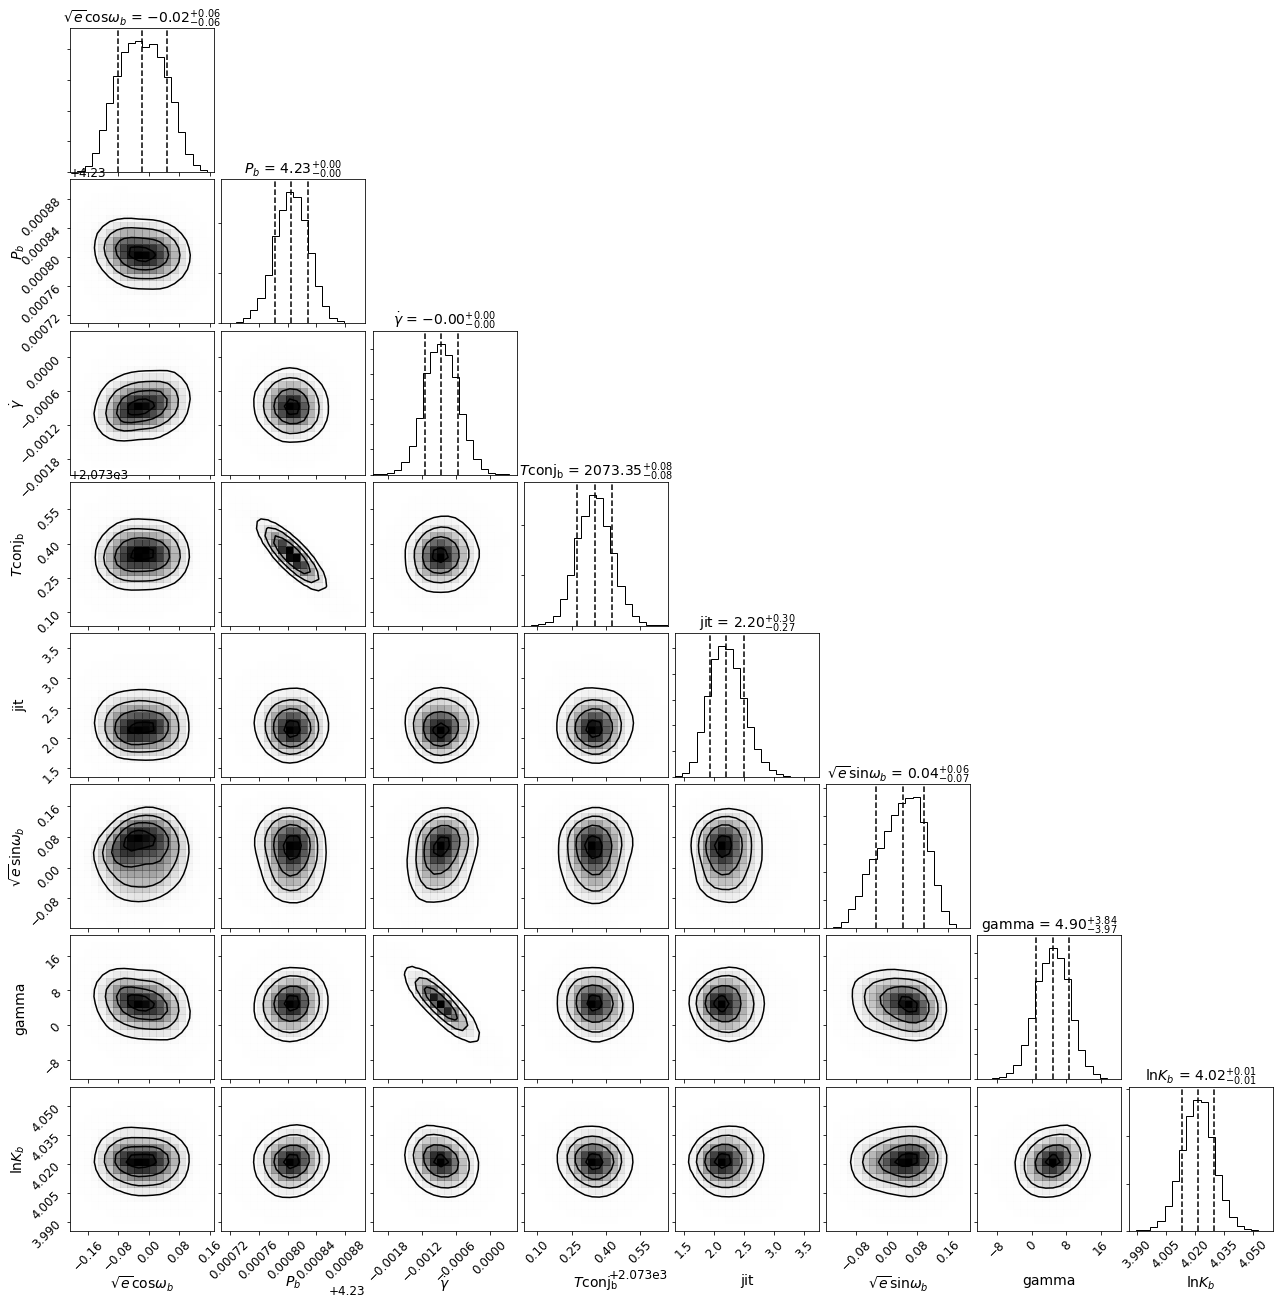

In [11]:
radvel.plotting.corner_plot(post, df)

### Eccentric Fit

Allow ``secosw`` and ``sesinw`` parameters to vary

In [12]:
like.vary.update(secosw1=True,
                 sesinw1=True,
                )

Add an ``EccentricityPrior`` to ensure that eccentricity stays below 1.0. In this example we will also add a Gaussian prior on the jitter (``jit``) parameter with a center at 2.0 m/s and a width of 0.1 m/s.

In [13]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.EccentricityPrior(1)]
# post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

Optimize the parameters by maximizing the likelihood and plot the result

parameter                     value      vary
curv                              0      False
dvdt                    -0.00106951       True
gamma                       7.64483       True
jit                         2.01484       True
logk1                       4.02307       True
per1                        4.23082       True
secosw1                  -0.0644284       True
sesinw1                    0.062452       True
tc1                         2073.32       True

Priors
------
e1 constrained to be < 0.99



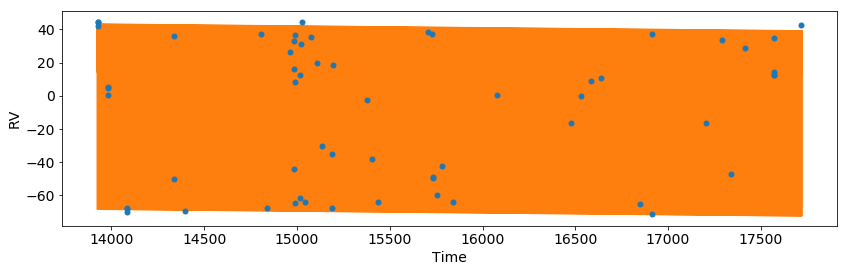

In [14]:
res  = optimize.minimize(
    post.neglogprob_array, 
    post.get_vary_params(), 
    method='Powell',)

plot_results(like)
print post

Run the MCMC again

In [15]:
df = radvel.mcmc(post,threads=1,nwalkers=20,nrun=10000)

24000/200000 (12.0%) steps complete; Running 7352.93 steps/s; Mean acceptance rate = 44.1%; Min Tz = 2129.6; Max G-R = 1.10 
Discarding burn-in now that the chains are marginally well-mixed

113000/200000 (56.5%) steps complete; Running 7246.38 steps/s; Mean acceptance rate = 43.0%; Min Tz = 7112.4; Max G-R = 1.03 
Chains are well-mixed after 114000 steps! MCMC completed in 16.9 seconds




Convert into more physical parameters and make another corner plot

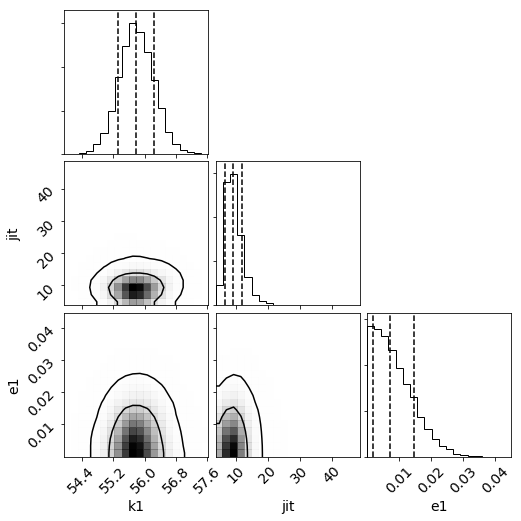

In [16]:
df['k1'] = np.exp(df['logk1'])
df['jit'] = np.exp(df['jit'])
df['e1'] = df['secosw1']**2 + df['sesinw1']**2


df['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])
df['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])


labels = 'k1 jit e1'.split()
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    quantiles=[.14,.5,.84]
    )

Plot the final solution

C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(<matplotlib.figure.Figure at 0x1405e240>,
  <matplotlib.axes._subplots.AxesSubplot at 0xcce2cc0>])

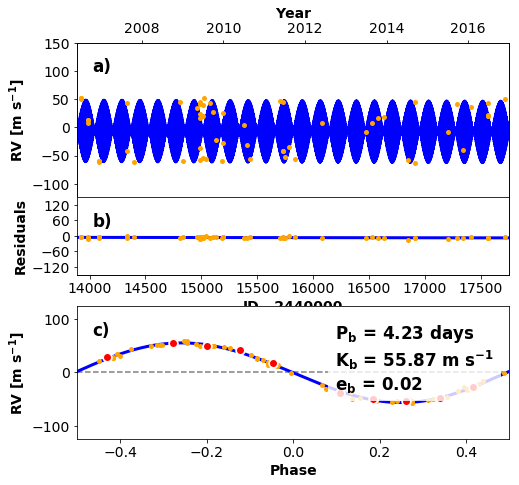

In [17]:
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [18]:
print post.residuals

<bound method Posterior.residuals of parameter                     value      vary
curv                              0      False
dvdt                   -0.000492458       True
gamma                     -0.122813       True
jit                         2.22442       True
logk1                       4.02307       True
per1                         4.2308       True
secosw1                  -0.0805104       True
sesinw1                   -0.106211       True
tc1                         2073.38       True

Priors
------
e1 constrained to be < 0.99
>
